In [68]:
# import required libraries/dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, Sequential

In [69]:
# training path
train_path = 'dataset/tusimple_preprocessed/training'

In [70]:
# create a generator and get the images from the directory
img_generator = keras.preprocessing.image.ImageDataGenerator()
seed = 10
images_set = img_generator.flow_from_directory(
    train_path,
    shuffle=False,
    batch_size=64,
    class_mode='binary',
    target_size=(256, 320)
)

Found 7252 images belonging to 2 classes.


In [71]:
'''
Assign the images in 'images_set' to two seperate arrays:
assign the road images to 'X' and the ground truth masks to 'Y'
'''
num_images = 7252 # gotten from the output of the cell above
num_batches = num_images // 64 + 1

# initialize an empty list to store the images
X = []
Y = []
# loop over the batches and extract the images
for i in range(num_batches):
    batch = next(images_set)
    batch_images = batch[0] # this contains the images
    batch_labels = batch[1] # this contains 0s and 1s
    for ind, lb in enumerate(batch_labels):
        '''
        a label of 0 means the image belongs to ground truth image,
        and a label of 1 means that the image belongs to the ground truth mask
        '''
        if lb == 0: 
            X.append(batch_images[ind])
        else:
            Y.append(np.mean(batch_images[ind], axis=2)) # Y shape is (m, 256, 320)
    if i % 10 == 0:
        print(f'Batch {i}')

# convert the lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Batch 50
Batch 60
Batch 70
Batch 80
Batch 90
Batch 100
Batch 110


In [72]:
# shuffle the dataset
from sklearn.utils import shuffle

X, Y = shuffle(X, Y, random_state=100)

In [73]:
# becacuse of lack of resources like RAM, we only get 2000 training samples
X = np.array(X[:2000])
Y = np.array(Y[:2000])


In [74]:
display(X.shape)
display(Y.shape)

(2000, 256, 320, 3)

(2000, 256, 320)

# Modelling

In [75]:
# Normalize and reshape the mask set (Y)
Y = (Y >= 100).astype('int').reshape(-1, 256, 320, 1)

In [76]:
# Split the datset into train and val sets
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=.1, random_state=100)

In [77]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of Y_val:", Y_val.shape)


Shape of X_train: (1800, 256, 320, 3)
Shape of X_val: (200, 256, 320, 3)
Shape of Y_train: (1800, 256, 320, 1)
Shape of Y_val: (200, 256, 320, 1)


In [78]:
# free the RAM from undesired clutters
import gc
del X, Y, images_set
gc.collect()


1481

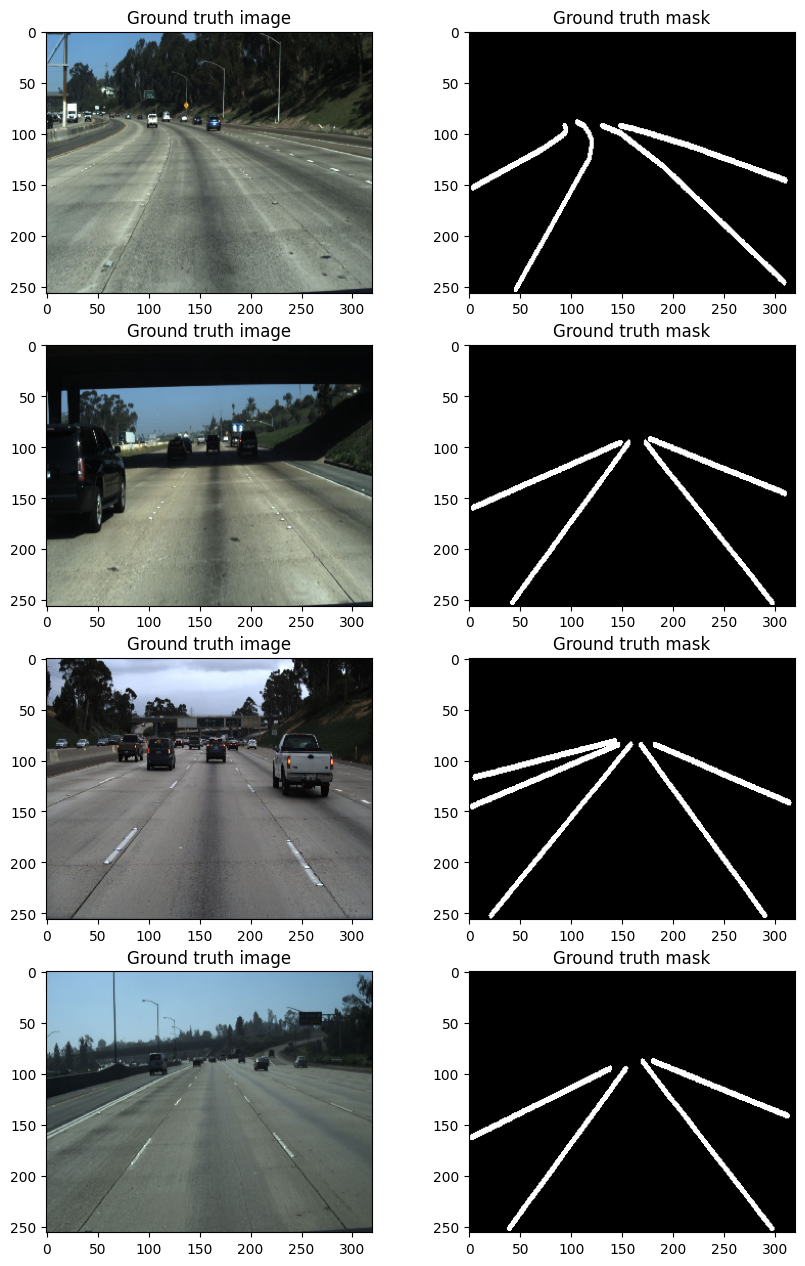

In [79]:
# visualize some samples from the training set
plt.figure(figsize=(10, 40))
s, e = 80, 84
index = 1

for i, j in zip(X_train[s:e], Y_train[s:e]):
    plt.subplot(10, 2, index)
    plt.imshow(i/255.)
    plt.title('Ground truth image')
    
    plt.subplot(10, 2, index+1)
    plt.imshow(j, cmap='gray')
    plt.title('Ground truth mask')
    index += 2

In [80]:
# model structure
from tensorflow.keras.layers import Input, Conv2DTranspose, Conv2D, MaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50

# Define the input shape of the images
input_shape = (256, 320, 3)

# Define the encoder using a pretrained ResNet50 model
encoder = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

'''
Find the index of the layer named conv3_block4_out of which output size is (32x32xnC)
 because we want to shrink the input's size down upto (32x32xnC) in the encoder section
'''

for i, layer in enumerate(encoder.layers):
    if layer.name == 'conv3_block4_out':
        break

# Create a new model that includes only the layers up to conv3_block4_out
encoder = tf.keras.Model(inputs=encoder.inputs, outputs=encoder.layers[i].output)

# Freeze the weights of the encoder layers to prevent them from being updated during training
for layer in encoder.layers[:50]:
    layer.trainable = False

# Define the decoder using a smaller FCN architecture
def decoder(inputs):
    conv1 = Conv2D(256, (3, 3), activation='relu', padding='same')(inputs)
    up1 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)
    up2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv2)
    
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
    up3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(up3)
    return outputs

# Define the input tensor
inputs = Input(input_shape)

# Pass the input through the encoder and decoder to obtain the output
outputs = decoder(encoder(inputs))

# Define the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)


94765736/94765736 [==============================] - 9s 0us/step


In [81]:
# Compile the model
model.compile(optimizer='adam', loss=keras.losses.BinaryFocalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 320, 3)]     0         
                                                                 
 model (Functional)          (None, 32, 40, 512)       1460096   
                                                                 
 conv2d_74 (Conv2D)          (None, 32, 40, 256)       1179904   
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 64, 80, 256)      262400    
 Transpose)                                                      
                                                                 
 conv2d_75 (Conv2D)          (None, 64, 80, 128)       295040    
                                                                 
 conv2d_transpose_13 (Conv2D  (None, 128, 160, 128)    65664     
 Transpose)                                                

In [82]:
# train the model
epochs = 32
batch_size = 8

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

model.fit(
    X_train,
    Y_train,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_val, Y_val),
    batch_size=batch_size
)

Epoch 1/32
225/225 [==============================] - 41s 126ms/step - loss: 0.0205 - accuracy: 0.9672 - val_loss: 0.0156 - val_accuracy: 0.9755
Epoch 2/32
225/225 [==============================] - 27s 122ms/step - loss: 0.0140 - accuracy: 0.9775 - val_loss: 0.0145 - val_accuracy: 0.9776
Epoch 3/32
225/225 [==============================] - 28s 122ms/step - loss: 0.0128 - accuracy: 0.9792 - val_loss: 0.0137 - val_accuracy: 0.9782
Epoch 4/32
225/225 [==============================] - 27s 122ms/step - loss: 0.0118 - accuracy: 0.9805 - val_loss: 0.0142 - val_accuracy: 0.9771
Epoch 5/32
225/225 [==============================] - 27s 122ms/step - loss: 0.0110 - accuracy: 0.9817 - val_loss: 0.0144 - val_accuracy: 0.9784
Epoch 6/32
225/225 [==============================] - 28s 123ms/step - loss: 0.0104 - accuracy: 0.9828 - val_loss: 0.0150 - val_accuracy: 0.9781
Epoch 7/32
225/225 [==============================] - 28s 123ms/step - loss: 0.0097 - accuracy: 0.9839 - val_loss: 0.0153 - val_ac

In [84]:
import gc
import tensorflow as tf

# Clear any unnecessary variables
tf.keras.backend.clear_session()
gc.collect()

# Make predictions again
preds = model.predict(X_val, batch_size=1)


200/200 [==============================] - 3s 13ms/step


In [85]:
# make a directory to store some predicted lane masks
!mkdir out

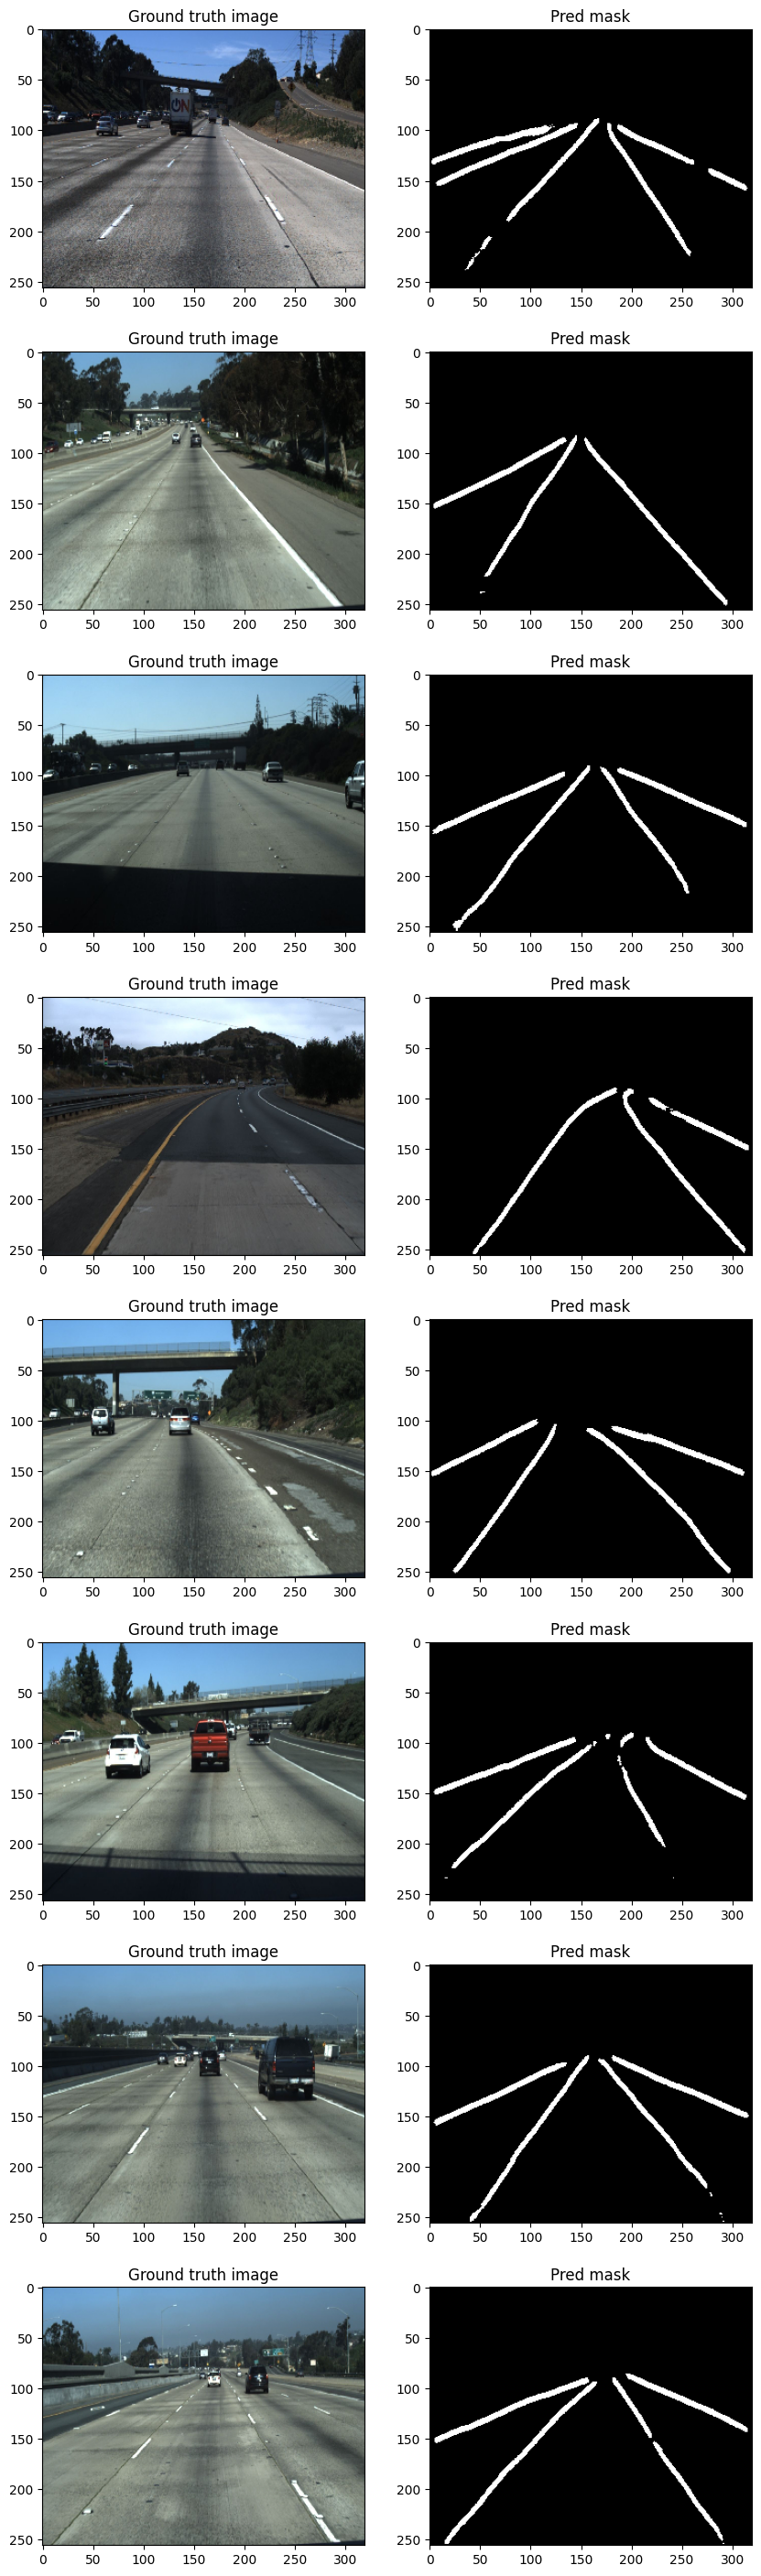

In [86]:
# visualize some results from the val set.
plt.figure(figsize=(10, 45))
s, e = 90, 98
index = 1

preds = (preds >= .5).astype('int')
for i, j, k in zip(X_val[s:e], preds[s:e], Y_val[s:e]):
    # write these images into file as well
    cv2.imwrite(f'./out/img-{index}.jpg', i)
    cv2.imwrite(f'./out/pred-{index}.jpg', j*255.)
    cv2.imwrite(f'./out/ground-{index}.jpg', k*255.)
    
    plt.subplot(10, 2, index)
    plt.imshow(i/255.)
    plt.title('Ground truth image')
    
    plt.subplot(10, 2, index+1)
    plt.imshow(j, cmap='gray')
    plt.title('Pred mask')
    index += 2

In [89]:
# create metrices
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recal = tf.keras.metrics.Recall()
iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])


# accuracy
accuracy.update_state(Y_val, preds)
accuracy_value = accuracy.result().numpy()
# precision
precision.update_state(Y_val, preds)
precision_value = precision.result().numpy()
# recal
recal.update_state(Y_val, preds)
recal_value = recal.result().numpy()
# f1 score
f1_score = 2 / ((1 / precision_value) + (1 / recal_value))

# Intersection over union (IoU)
iou.update_state(Y_val, preds)
iou_value = iou.result().numpy()

print("Accuracy:", accuracy_value)
print("Precision:", precision_value)
print("Recal:", recal_value)
print('F1 Score: ', f1_score)
print('IoU: ', iou_value)

Accuracy: 0.97836673
Precision: 0.7716041
Recal: 0.7145851
F1 Score:  0.7420008304134839
IoU:  0.58982617
